# The objective of this notebook is to test the hypothesis that the effect of tFUS is dependent on the distance from the scalp location of the transducer to the intented target (i.e., sgACC). To test this we will perform simple correlation/regression tests.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nibabel as nib
from nilearn import input_data, datasets, plotting, signal
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
## Load the precomputed dataframe
path_to_df = '../data/precomputed/df_fc.pkl'
df = pd.read_pickle(path_to_df)
difumo = datasets.fetch_atlas_difumo(dimension=1024)
df_labels = pd.DataFrame(difumo.labels)  # List of 1024 anatomical labels
subgenual = df_labels.loc[133,'difumo_names']
df["is_roi1_subgenual"] = df["roi1"] == subgenual
df["is_roi2_subgenual"] = df["roi2"] == subgenual
df["is_pair_subgenual"] = df["is_roi1_subgenual"] | df["is_roi2_subgenual"]
df_sg = df[df["is_pair_subgenual"]].copy()
df_sg["roi_pair"] = ["__".join(sorted((r1, r2))) for r1, r2 in zip(df_sg["roi1"], df_sg["roi2"])]
dfw = df_sg.copy().drop(columns=["roi1", "roi2", "is_roi1_subgenual", "is_roi2_subgenual", "is_pair_subgenual","roi_pair"]).reset_index(drop=True)

In [3]:
dfw_mu = (
    dfw
    .groupby(["subject", "condition", "time_window"], as_index=False)["fc"]
    .mean()
)

dfw_mu

,subject,condition,time_window,fc
0,0,active,fus,-0.008226
1,0,active,post,-0.015510
2,0,active,pre,-0.038423
3,0,sham,fus,0.187012
4,0,sham,post,0.145867
...,...,...,...,...
91,15,active,post,0.055851
92,15,active,pre,0.035226
93,15,sham,fus,-0.066011
94,15,sham,post,0.067159


In [5]:
# baseline at the subject × condition level
dfw_mu["subject_condition"] = list(zip(dfw_mu["subject"], dfw_mu["condition"]))
baseline_lookup = (
    dfw_mu[dfw_mu["time_window"] == "pre"]
    .set_index("subject_condition")["fc"]
    .to_dict()
)

dfw_mu["baseline_fc"] = dfw_mu["subject_condition"].map(baseline_lookup)
dfw_mu = dfw_mu.dropna(subset=["baseline_fc"]).reset_index(drop=True)
dfw_mu["delta_fc"] = dfw_mu["fc"] - dfw_mu["baseline_fc"]

In [11]:
dfw_mu_active = dfw_mu[dfw_mu["condition"] == "active"].copy()
dfw_mu_active = dfw_mu_active[dfw_mu_active["time_window"] != "pre"]
dfw_mu_active_fus = dfw_mu_active[dfw_mu_active["time_window"] == "fus"].copy()
dfw_mu_active_post = dfw_mu_active[dfw_mu_active["time_window"] == "post"].copy()
dfw_mu_active_fus, dfw_mu_active_post

(    subject condition time_window        fc subject_condition  baseline_fc  \
 0         0    active         fus -0.008226       (0, active)    -0.038423   
 6         1    active         fus  0.198388       (1, active)     0.149917   
 12        2    active         fus  0.119737       (2, active)     0.050299   
 18        3    active         fus -0.053764       (3, active)    -0.044775   
 24        4    active         fus  0.189621       (4, active)     0.180382   
 30        5    active         fus  0.106818       (5, active)     0.049109   
 36        6    active         fus  0.119549       (6, active)     0.104533   
 42        7    active         fus  0.207135       (7, active)     0.061414   
 48        8    active         fus  0.087459       (8, active)    -0.007046   
 54        9    active         fus  0.096814       (9, active)     0.168231   
 60       10    active         fus  0.111508      (10, active)     0.083190   
 66       11    active         fus  0.104179      (1

In [27]:
path_to_csv = '../data/scalp-target-distances/sgACC_Summary_Stats.csv'
dfd = pd.read_csv(path_to_csv)
distances = dfd.iloc[0:16,1].values
dfd

,Subject,Distance_mm,Azimuth_deg,Elevation_deg
0,Adler,71.060000,-105.610000,-6.460000
1,Ahmed,80.410000,-98.640000,-6.430000
2,Allahabi,74.030000,-108.920000,1.550000
3,Boyer,73.460000,-101.630000,-19.070000
4,Cabrera,79.300000,-100.180000,-2.170000
5,Coache,80.490000,-100.890000,9.300000
6,Ghosh,66.990000,-102.340000,-12.060000
7,Jayanthi,80.760000,-106.630000,5.690000
8,Lin,69.900000,-98.250000,-4.100000
9,Macauley,76.650000,-101.310000,-3.740000


np.float64(-0.0636610106139689)

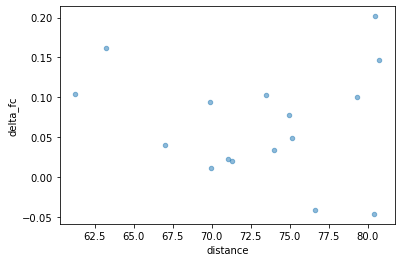

In [26]:
# wild guess scatter plot
dfw_mu_active_fus["distance"] = distances
dfw_mu_active_post["distance"] = distances

#dfw_mu_active_fus

#dfw_mu_active_fus.plot.scatter(x="distance", y="delta_fc", alpha=0.5)
dfw_mu_active_post.plot.scatter(x="distance", y="delta_fc", alpha=0.5)

dfw_mu_active_post["distance"].corr(dfw_mu_active_post["delta_fc"])

In [14]:
# try to reconstruct the order that the subjects were read in and dumped into the precomputed pickled dataframes
import os
data_root = "/Volumes/jacekdmochowski/PROJECTS/fus/data/resampled_bold_flywheel/"
folders = [f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, f))]

for folder in folders:
    print(folder)

resampled_bold_sub-RAMNAUTH_ses-ACTIVE--2024-10-11
resampled_bold_sub-MATHAI_ses-SHAM_1--2024-09-27
resampled_bold_sub-GHOSH_ses-ACTIVE--2024-09-13
resampled_bold_sub-MACAULEY_ses-SHAM--2024-09-19
resampled_bold_sub-COACHE_ses-ACTIVE--2024-09-13
resampled_bold_sub-ALLAHABI_ses-ACTIVE--2024-09-13
resampled_bold_sub-RAHMAN_ses-SHAM--2024-09-20
resampled_bold_sub-RYAN_ses-ACTIVE--2024-09-13
resampled_bold_sub-LIN_ses-SHAM--2024-09-13
resampled_bold_sub-LIN_ses-ACTIVE--2024-09-13
resampled_bold_sub-JAYANTHI_ses-ACTIVE--2024-10-11
resampled_bold_sub-CABRERA_ses-SHAM--2024-09-19
resampled_bold_sub-ADLER_ses-SHAM--2024-09-13
resampled_bold_sub-RYAN_ses-SHAM--2024-09-19
resampled_bold_sub-AHMED_ses-SHAM--2024-09-19
resampled_bold_sub-BOYER_ses-ACTIVE--2024-09-27
resampled_bold_sub-ALLAHABI_ses-SHAM--2024-09-27
resampled_bold_sub-CABRERA_ses-ACTIVE--2024-09-13
resampled_bold_sub-AHMED_ses-ACTIVE--2024-09-13
resampled_bold_sub-COACHE_ses-SHAM--2024-09-27
resampled_bold_sub-JAYANTHI_ses-SHAM--202

In [16]:
baseline_lookup[(0, 'active')]

-0.2751258925237833

In [14]:
dfw

,fc,subject,time_window,condition,subject_condition,baseline_fc,delta_fc
0,-0.123240,0,pre,active,"(0, active)",-0.275126,0.151885
1,-0.221344,0,pre,active,"(0, active)",-0.275126,0.053782
2,-0.068318,0,pre,active,"(0, active)",-0.275126,0.206808
3,-0.306134,0,pre,active,"(0, active)",-0.275126,-0.031008
4,-0.292831,0,pre,active,"(0, active)",-0.275126,-0.017705
...,...,...,...,...,...,...,...
98203,0.043532,15,post,sham,"(15, sham)",-0.077831,0.121364
98204,0.203698,15,post,sham,"(15, sham)",-0.077831,0.281529
98205,0.059240,15,post,sham,"(15, sham)",-0.077831,0.137072
98206,0.251253,15,post,sham,"(15, sham)",-0.077831,0.329085


In [15]:
dfw[dfw["time_window"] == "pre"].set_index("subject_condition")["fc"]

subject_condition
(0, active)   -0.123240
(0, active)   -0.221344
(0, active)   -0.068318
(0, active)   -0.306134
(0, active)   -0.292831
                 ...   
(15, sham)     0.097697
(15, sham)    -0.218724
(15, sham)    -0.256767
(15, sham)    -0.077530
(15, sham)    -0.077831
Name: fc, Length: 32736, dtype: float64